# Rules Compression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Importing dataset 

In [2]:
df = pd.read_csv('dataset.tsv', sep='\t')
df.columns = df.columns.str.replace('α', 'alpha').str.replace('β', 'beta').str.replace('γ', 'gamma')

In [3]:
df.head()

,donor_is_old,BMI,WBC,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,Neutrophils_percent,Lymphocytes_percent,...,IL_2,IL_4,IL_6,IL_8,TNF_alpha,sCD86,GDF_15,SOST,OMD,Notch_1
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
1,False,True,False,False,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
2,False,True,True,True,True,False,False,False,False,False,...,True,True,True,False,True,False,False,False,NaN,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,True,True,False,...,False,False,True,True,False,False,False,False,False,False


In [4]:
df.describe()

,donor_is_old,BMI,WBC,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,Neutrophils_percent,Lymphocytes_percent,...,IL_2,IL_4,IL_6,IL_8,TNF_alpha,sCD86,GDF_15,SOST,OMD,Notch_1
count,39,39,39,36,39,39,36,39,35,39,...,39,39,39,39,39,39,38,38,37,37
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
freq,20,28,29,27,29,29,27,26,26,29,...,29,29,39,29,29,29,28,28,27,27


## Visualization

### Heatmap

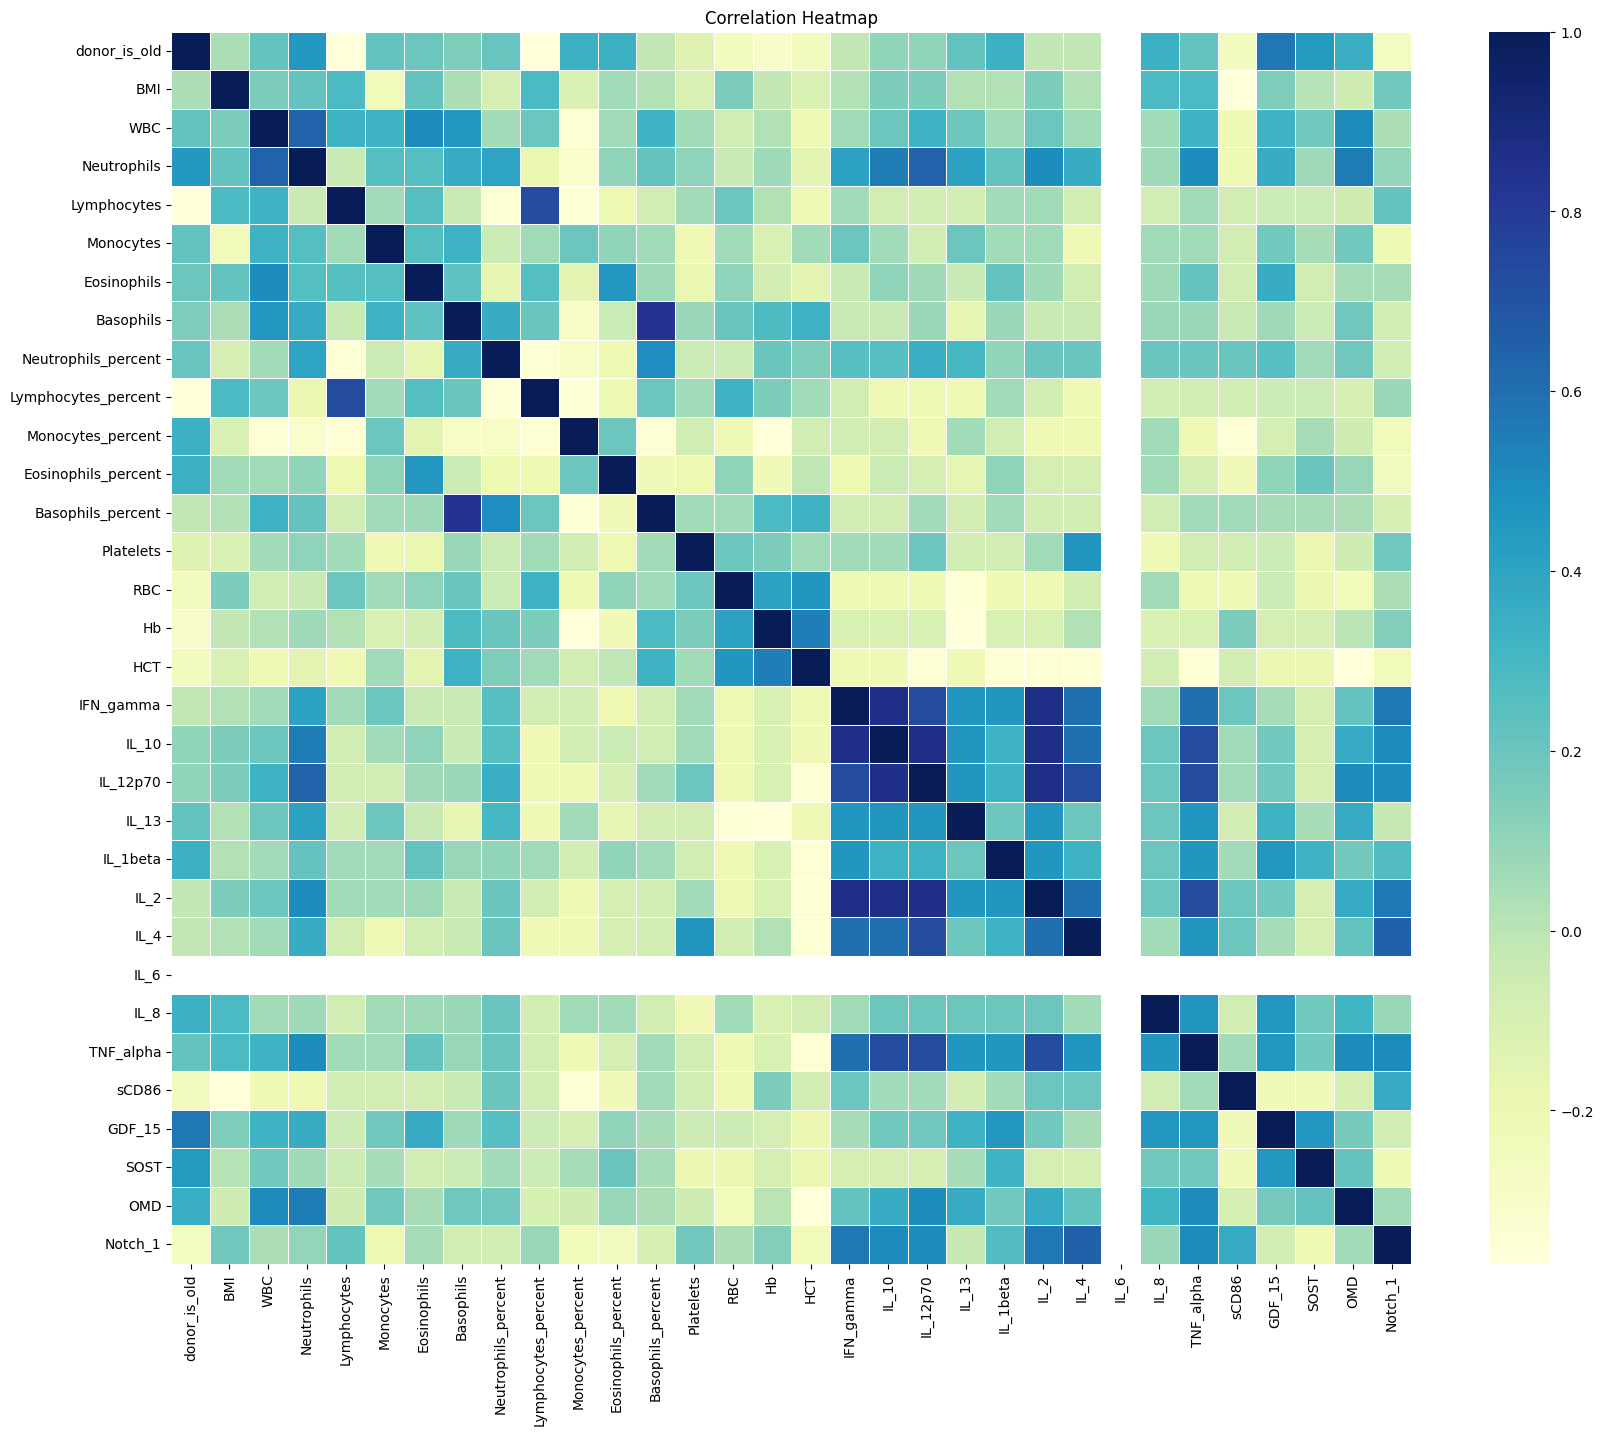

In [5]:
# Heatmap to Visualize Correlation

# Heatmap to visualize correlation between numerical columns
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### 
Not notch_1 \
GDF_15 \
SOST\
not sD86\
Il_1beta\
not hct\
not Hb\
not rbc\
eosinophilis percent\
eosinophilis\
monocyths percent\
monocytes\
not Lymphocytes\
not Lymphocytes_percent\
Neutrophils

### Replacing greece letters

In [6]:
greece = {
    'α': 'alpha',
    'β': 'beta',
    'γ': 'gamma'
}

## Scoring rules

### Getting labels from rules

In [7]:
def return_labels(rule):
    current = rule[0]
    #print(current)
    i = 0
    positive = 1
    actual = ""
    positives = []
    negatives = []
    #print(len(rule))
    while rule[i]  != '>':
        #print(rule[i])
        #print(i)
        if rule[i] == 'N' and rule[i+1] == 'O' and rule[i+2] == 'T':
            #print('NOT')
            positive = 0
            i+=3
            continue
        elif rule[i] == 'A':
            #print('AND')
            i+=3
            if positive == 1:
                positives.append(str(actual))
                #print(str(actual) + " is positive")
            elif positive == 0:
                negatives.append(str(actual))
                #print(str(actual) + " is negative")
            actual = ""
            positive = 1
            continue
        elif rule[i] == ' ':
            i+=1
            continue
        elif rule[i] == '=':
            if positive == 1:
                positives.append(str(actual))
                #print(str(actual) + " is positive")
            elif positive == 0:
                negatives.append(str(actual))
                #print(str(actual) + " is negative")
            i+=1
        else:
            if rule[i] in greece:
                actual += greece[rule[i]]
            else:
                actual += rule[i]
            i+=1
    return positives, negatives
def return_negative(rule):
    return 'Hb', 'Monocytes', 'Notch_1'

def negation(value):
    return  (value-1)**2

In [8]:
import numpy as np
df = df.map(lambda x: 1 if x is True else (0 if x is False else x))
df = df.apply(pd.to_numeric, errors='coerce').fillna(-1)
df['donor_is_old'][0]
df.shape

(39, 32)

### Looping through rules

In [9]:
rules_path = "rules.txt"
accuracy = []
rules_dict = {}
rules_list = []
with open(rules_path, "r") as rules:
    for rule in rules:
        rules_list.append(rule)
        positive_labels, negative_labels = return_labels(rule)
        #print(positive_labels)
        #print(negative_labels)
        #print(len(df))
        correct = 0
        for i in range(39):
            result = 1.0
            for label in positive_labels:
                result = result * float(df[label][i])
            for label in negative_labels:
                result = result * negation(float(df[label][i]))
            correct += int(result == float(df['donor_is_old'][i]))
        accuracy.append(correct / 39)
        rules_dict[rule] = correct / 39
i=1
for key in rules_dict:
    print(f'{i}: {key} -> {rules_dict[key]}')
    i+=1



1: Monocytes AND NOT sCD86 => donor_is_old
 -> 0.6410256410256411
2: TNF_α => donor_is_old
 -> 0.5897435897435898
3: NOT Hb AND NOT Monocytes AND NOT Notch_1 => donor_is_old
 -> 0.6666666666666666
4: OMD => donor_is_old
 -> 0.6153846153846154
5: NOT Hb AND NOT Notch_1 => donor_is_old
 -> 0.717948717948718
6: IL_10 => donor_is_old
 -> 0.5384615384615384
7: NOT Notch_1 => donor_is_old
 -> 0.5897435897435898
8: SOST => donor_is_old
 -> 0.6666666666666666
9: WBC => donor_is_old
 -> 0.5897435897435898
10: Eosinophils => donor_is_old
 -> 0.5384615384615384
11: NOT IL_4 AND NOT Lymphocytes => donor_is_old
 -> 0.6666666666666666
12: Monocytes_percent => donor_is_old
 -> 0.6410256410256411
13: NOT Hb AND NOT Lymphocytes_percent => donor_is_old
 -> 0.7435897435897436
14: NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 -> 0.8205128205128205
15: NOT IFN_γ => donor_is_old
 -> 0.5128205128205128
16: Eosinophils_percent => donor_is_old
 -> 0.5897435897435898
17: NOT Basophils_percent AND 

### Removing rules that are worse than 70% accuracy

In [10]:
for key in rules_dict:
    if rules_dict[key] < 0.7:
        rules_list.remove(key)
        print(f'{key} removed, acc: {rules_dict[key]}')

Monocytes AND NOT sCD86 => donor_is_old
 removed, acc: 0.6410256410256411
TNF_α => donor_is_old
 removed, acc: 0.5897435897435898
NOT Hb AND NOT Monocytes AND NOT Notch_1 => donor_is_old
 removed, acc: 0.6666666666666666
OMD => donor_is_old
 removed, acc: 0.6153846153846154
IL_10 => donor_is_old
 removed, acc: 0.5384615384615384
NOT Notch_1 => donor_is_old
 removed, acc: 0.5897435897435898
SOST => donor_is_old
 removed, acc: 0.6666666666666666
WBC => donor_is_old
 removed, acc: 0.5897435897435898
Eosinophils => donor_is_old
 removed, acc: 0.5384615384615384
NOT IL_4 AND NOT Lymphocytes => donor_is_old
 removed, acc: 0.6666666666666666
Monocytes_percent => donor_is_old
 removed, acc: 0.6410256410256411
NOT IFN_γ => donor_is_old
 removed, acc: 0.5128205128205128
Eosinophils_percent => donor_is_old
 removed, acc: 0.5897435897435898
NOT Basophils_percent AND NOT Notch_1 => donor_is_old
 removed, acc: 0.6410256410256411
NOT Basophils_percent AND NOT IL_12p70 => donor_is_old
 removed, acc: 0

### Checking if some of the rules aren't overspecifing - doesn't work only for one type of donors (old/young)

In [11]:

rules_old_dict = {}
for rule in rules_list:
    positive_labels, negative_labels = return_labels(rule)
    correct = 0
    for i in range(19, 39):
        result = 1.0
        for label in positive_labels:
            result = result * float(df[label][i])
        for label in negative_labels:
            result = result * negation(float(df[label][i]))
        correct += int(result == float(df['donor_is_old'][i]))
    rules_old_dict[rule] = correct / 20
i=1
for key in rules_old_dict:
    print(f'{i}: {key} acc: {rules_old_dict[key]}')
    i+=1

1: NOT Hb AND NOT Notch_1 => donor_is_old
 acc: 0.75
2: NOT Hb AND NOT Lymphocytes_percent => donor_is_old
 acc: 0.8
3: NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.75
4: NOT Lymphocytes AND NOT sCD86 => donor_is_old
 acc: 0.75
5: NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.8
6: GDF_15 => donor_is_old
 acc: 0.5
7: NOT Lymphocytes_percent AND NOT Notch_1 => donor_is_old
 acc: 0.8
8: NOT HCT AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.65
9: NOT Hb AND NOT Lymphocytes => donor_is_old
 acc: 0.8
10: NOT Basophils AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.55
11: NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.65


### Removing overspecific rules

In [12]:
for key in rules_old_dict:
    if rules_old_dict[key] < 0.7:
        rules_list.remove(key)
        print(f'{key} removed, acc for old donors: {rules_old_dict[key]}')

GDF_15 => donor_is_old
 removed, acc for old donors: 0.5
NOT HCT AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 removed, acc for old donors: 0.65
NOT Basophils AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 removed, acc for old donors: 0.55
NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 removed, acc for old donors: 0.65


### Checking overspecification for only young

In [13]:
rules_young_dict = {}
for rule in rules_list:
    positive_labels, negative_labels = return_labels(rule)
    correct = 0
    for i in range(19):
        result = 1.0
        for label in positive_labels:
            result = result * float(df[label][i])
        for label in negative_labels:
            result = result * negation(float(df[label][i]))
        correct += int(result == float(df['donor_is_old'][i]))
    rules_young_dict[rule] = correct / 19
i=1
for key in rules_young_dict:
    print(f'{i}: {key} acc: {rules_young_dict[key]}')
    i+=1

1: NOT Hb AND NOT Notch_1 => donor_is_old
 acc: 0.6842105263157895
2: NOT Hb AND NOT Lymphocytes_percent => donor_is_old
 acc: 0.6842105263157895
3: NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.8947368421052632
4: NOT Lymphocytes AND NOT sCD86 => donor_is_old
 acc: 0.6842105263157895
5: NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 acc: 0.6842105263157895
6: NOT Lymphocytes_percent AND NOT Notch_1 => donor_is_old
 acc: 0.7368421052631579
7: NOT Hb AND NOT Lymphocytes => donor_is_old
 acc: 0.7368421052631579


### Removig overspecific

In [14]:
for key in rules_young_dict:
    if rules_young_dict[key] < 0.7:
        if key in rules_list:
            print('ashdfasdjfaslkfjsafh')
            rules_list.remove(key)
            print(f'{key} removed, acc for young donors: {rules_young_dict[key]}, acc for old donors: {rules_old_dict[key]}')

ashdfasdjfaslkfjsafh
NOT Hb AND NOT Notch_1 => donor_is_old
 removed, acc for young donors: 0.6842105263157895, acc for old donors: 0.75
ashdfasdjfaslkfjsafh
NOT Hb AND NOT Lymphocytes_percent => donor_is_old
 removed, acc for young donors: 0.6842105263157895, acc for old donors: 0.8
ashdfasdjfaslkfjsafh
NOT Lymphocytes AND NOT sCD86 => donor_is_old
 removed, acc for young donors: 0.6842105263157895, acc for old donors: 0.75
ashdfasdjfaslkfjsafh
NOT Lymphocytes AND NOT Notch_1 => donor_is_old
 removed, acc for young donors: 0.6842105263157895, acc for old donors: 0.8


## Summary

In [15]:
i=1
for rule in rules_list:
    print(f'{i}. {rule}acc: {rules_dict[rule]:.2f}, old acc: {rules_old_dict[rule]:.2f}, young acc: {rules_young_dict[rule]:.2f}')
    i+=1

1. NOT Hb AND NOT Lymphocytes AND NOT Notch_1 => donor_is_old
acc: 0.82, old acc: 0.75, young acc: 0.89
2. NOT Lymphocytes_percent AND NOT Notch_1 => donor_is_old
acc: 0.77, old acc: 0.80, young acc: 0.74
3. NOT Hb AND NOT Lymphocytes => donor_is_old
acc: 0.77, old acc: 0.80, young acc: 0.74


### Saving rules to new file

In [16]:
with open ('new_rules.txt', 'w') as rules:
    for rule in rules_list:
        rules.write(rule)
